# Australia Key Priority Route Average Travel Times

**Travel Times for key priority routes 2022-2023**:
https://www.data.qld.gov.au/dataset/travel-times-for-key-priority-routes-2022

Queensland Average Travel Times for key priority routes on the state controlled road network broken down in 15 minute regular intervals.


In [1]:
import sys
sys.path.append("..")

import os
import torch
from omegaconf import OmegaConf

from src.datasets.sim import SimDataset
from src.train import Trainer
from src.utils import chain_mat_to_ten, chain_ten_to_mat, ten_to_mat, qmat_to_pmat
from src.chains.generation import *

import numpy as np
import pandas as pd
from datetime import date, datetime, timedelta
import matplotlib.pyplot as plt

madmap = 'hot'
NUM_COLUMNS = 218
month_to_int = dict(zip(['JAN','FEB','MAR','APR','MAY','JUN','JUL','AUG','SEP','OCT','NOV','DEC'],
                        [i+1 for i in range(12)]))

def date_from_interval(intr):
    split_interval_str = intr.split(' ')
    dt,ti = split_interval_str[0], split_interval_str[1]

    if '/' in dt:
        dy_str, mo_str, yr_str = dt.split('/')
    elif '-' in dt:
        dy_str, mo_str, yr_str = dt.split('-')
    else:
        print(f"Invalid date string `{dt}`.")
        return
    dy = int(dy_str)
    yr = int(yr_str)
    mo = month_to_int[mo_str] if mo_str.upper() in month_to_int.keys() else int(mo_str)

    split_time_str = ti.split(':')
    hr,mn = int(split_time_str[0]), int(split_time_str[1])
    # hr,mn = list(map(int,ti.split(':')))
    end_time = datetime(yr,mo,dy,hr,mn,0)
    return end_time

def hour_to_window(h,num_windows=6):
    return int(np.where( h/23*num_windows >= np.arange(num_windows) )[0].max())

def month_to_season(mo,num_seasons=6):
    return int(np.where( mo/11*num_seasons >= np.arange(num_seasons) )[0].max())


In [2]:
def load_route_data(route_path,num_seasons:int=3,num_windows:int=6):
    # Four dimensions: Month, day of week, time window, and station
    D = 4
    I0 = num_seasons
    I1 = 7
    I2 = num_windows
    Is_time = [I0,I1,I2]
    time_columns = ['season','day','time_of_day']

    # Load route data, which contains transitions between stations
    #   Columns represent pairs of stations, rows are the end of 15-minute windows
    #   Nonzero entries show the duration of each transition, which can be used to approximate the start time of each transition
    #   For now, the end time of the 15-minute interval is assumed to be arrival time
    route_data = pd.read_csv(route_path)
    if all(route_data.iloc[:,-1].isna()):
        route_data = route_data.astype(float)
        route_data.iloc[:,1:] = route_data.to_numpy()[:,:-1]
        route_data[route_data.columns[0]] = route_data.index
        route_data.reset_index(drop=True, inplace=True)
    route_data = route_data.rename(columns=dict(zip(route_data.columns,[col.replace("'","").lower() for col in route_data.columns])))
    links = list(np.unique(route_data.columns[1:]))

    route_end_strs = route_data['interval_end'].to_list()
    route_end_dates = [date_from_interval(i) for i in route_end_strs]
    route_end_season = [month_to_season(i.month-1) for i in route_end_dates]
    route_end_weekdays = [i.weekday() for i in route_end_dates]
    route_end_window = [hour_to_window(i.hour) for i in route_end_dates]

    route_data['season'] = route_end_season
    route_data['day'] = route_end_weekdays
    route_data['time_of_day'] = route_end_window
    route_data = route_data[['interval_end'] + time_columns + links]

    transition_data = route_data.iloc[:,len(time_columns)+1:]
    num_transitions = (transition_data > 0).to_numpy().sum().item()
    # All pairs of stations
    # transits = transition_data.columns

    # Unique station numbers obtained from every station pair in route data
    stations = np.unique(sum([list(map(int,link.split('->'))) for link in links], []))
    num_stations = len(stations)
    Is = torch.tensor(Is_time + [num_stations])

    return dict(
        route_data=route_data,
        stations=stations,
        Is=Is,
    )

def merge_route_data(route_data_list):
    assert all([set(route_data_list[0]['stations'])==set(route_data['stations']) for route_data in route_data_list]), "Inconsistent stations across route datasets."
    assert all([(route_data_list[0]['Is']==route_data['Is']).all() for route_data in route_data_list]), "Inconsistent dimensions across route datasets."
    route_data_concat = pd.concat([route_data['route_data'] for route_data in route_data_list])

    return dict(
        route_data=route_data_concat,
        stations=route_data_list[0]['stations'],
        Is=route_data_list[0]['Is'],
    )

def top_k_stations(route_data,stations,Is,top_k:int=20):
    D = len(Is)
    transition_data = route_data.iloc[:,D:]
    transits = transition_data.columns
    num_stations = len(stations)

    # Find the top stations based on number of transits
    trips_per_transit = (transition_data>0).sum(0).to_numpy()
    trips_per_station = np.zeros(num_stations)
    for i_st,station in enumerate(stations):
        # Columns containing the current station
        selected_columns = np.array([j for j,transit in enumerate(transits) if str(station) in transit])
        trips_per_station[i_st] = trips_per_transit[selected_columns].sum()
        # trips_per_station[i_st] = len(selected_columns)
    top_station_inds = np.argsort(trips_per_station)[-top_k:]
    top_stations = stations[top_station_inds]
    return top_stations

def select_stations(route_data,stations,Is,selected_stations):
    D = len(Is)
    transition_data = route_data.iloc[:,D:]
    transits = transition_data.columns
    num_selected_stations = len(selected_stations)

    # Keep only the columns connecting the selected stations
    selected_transit_inds = []
    for i_tr,transit in enumerate(transits):
        start_station, end_station = list(map(int,transit.split('->')))
        if start_station in selected_stations and end_station in selected_stations:
            selected_transit_inds.append(i_tr)
    selected_transits = transits[selected_transit_inds]
    selected_route_data = route_data[list(route_data.columns[:D]) + list(selected_transits)]

    Is[-1] = num_selected_stations

    return dict(
        route_data=selected_route_data,
        stations=selected_stations,
        Is=Is
    )

def get_trajectory_data(route_data,stations,Is,num_seasons:int=None,num_windows:int=None):
    D = len(Is)
    transition_data = route_data.iloc[:,D:]
    transits = transition_data.columns
    route_end_strs = route_data['interval_end'].to_list()
    route_end_dates = [date_from_interval(i) for i in route_end_strs]
    if num_seasons is None:
        num_seasons = route_data['season'].nunique()
    if num_windows is None:
        num_windows = route_data['time_of_day'].nunique()

    station_to_ind = lambda s: np.where(stations==s)[0].item()
    # All transitions in data
    transition_list = []
    for i_col, col in enumerate(transits):
        # For a given ordered pair of stations, find transits
        durations = transition_data.iloc[:,i_col]
        transit_inds = np.where(durations>0)[0]

        # If no transits between given pair of stations, skip this column
        if len(transit_inds) == 0:
            continue

        # Get start and end stations
        start_str, end_str = col.split('->')
        start_station, end_station = station_to_ind(int(start_str)), station_to_ind(int(end_str))

        transitions = [None] * len(transit_inds)
        for i_tr,ind in enumerate(transit_inds):
            end_date = route_end_dates[ind]
            duration = timedelta(seconds=float(durations.iloc[ind]))
            start_date = end_date - duration

            start_season, end_season = month_to_season(start_date.month-1,num_seasons), month_to_season(end_date.month-1,num_seasons)
            start_day, end_day = start_date.weekday(), end_date.weekday()
            start_window, end_window = hour_to_window(start_date.hour,num_windows), hour_to_window(end_date.hour,num_windows)

            transitions[i_tr] = [start_season,start_day,start_window,start_station, end_season,end_day,end_window,end_station]
        
        transition_list += transitions

    X_all_steps = np.array(transition_list).T

    return X_all_steps

def empirical_transit_mc(X_all_steps,Is):
    D = len(Is)
    I = Is.prod().item()
    N = X_all_steps.shape[1]

    X_steps, counts = np.unique(X_all_steps, axis=1, return_counts=True)
    pairwise_counts = torch.zeros(tuple(Is.repeat(2)))
    pairwise_counts[*list(map(tuple,X_steps))] = torch.tensor(counts).to(torch.float)
    marginal_counts = pairwise_counts.sum(tuple(range(D,2*D)),keepdim=True)
    mask = (marginal_counts == 0).expand_as(pairwise_counts)

    Q = pairwise_counts / N
    R = marginal_counts.squeeze()
    P = pairwise_counts / marginal_counts
    P[mask] = 1.0 / I

    mct = MarkovChainTensor(torch.eye(2))
    mct.D = D
    mct.Is = Is
    mct.I = I
    mct.P = P
    mct.Q = Q
    mct.R = R

    mcm_inner = MarkovChainMatrix(torch.eye(2))
    mcm_inner.P = ten_to_mat(P,I)
    mcm_inner.Q = ten_to_mat(Q,I)
    mcm_inner.R = .5 * (mcm_inner.Q.sum(0) + mcm_inner.Q.sum(1))
    mcm_inner.current_state = torch.multinomial(mcm_inner.R,1).item()
    mcm_inner.I = mcm_inner.P.shape[0]
    mct._mcm = mcm_inner
    mct.current_state = torch.tensor( np.unravel_index(mct._mcm.current_state, tuple(mct.Is)), dtype=torch.long )

    return mct


In [4]:
# Dimensions: Seasons (groups of months), days of week, windows (groups of hours per day), stations

num_seasons = 1 # Split up 12 months into seasons
num_windows = 6 # Split up 24-hour day into windows
D = 4
top_k = 20 # Keep only the top 20 stations based on how many transitions each station involved in

yr = 2022
route_paths = [
    f"data/data_Queensland/routes-{mo}-{yr}.csv" 
    # for mo in ['january','february','march','april','may','june','july','august','september','october','november','december']
    for mo in ['january','february','march']
]
route_dict_list = [load_route_data(route_path,num_seasons,num_windows) for route_path in route_paths]
route_dict = merge_route_data(route_dict_list)

top_stations = top_k_stations(**route_dict,top_k=top_k)
route_dict = select_stations(**route_dict,selected_stations=top_stations)
X_all_steps = get_trajectory_data(**route_dict,num_seasons=num_seasons,num_windows=num_windows)
mct = empirical_transit_mc(X_all_steps,route_dict['Is'])

In [5]:
yr = 2022
route_paths = [
    f"data/data_Queensland/routes-{mo}-{yr}.csv" 
    # for mo in ['january','february','march','april','may','june','july','august','september','october','november','december']
    for mo in ['may','june','july']
]
route_dict_list = [load_route_data(route_path,num_seasons,num_windows) for route_path in route_paths]
route_dict = merge_route_data(route_dict_list)

route_dict = select_stations(**route_dict,selected_stations=top_stations)
X_all_steps = get_trajectory_data(**route_dict,num_seasons=num_seasons,num_windows=num_windows)
mct_obs = empirical_transit_mc(X_all_steps,route_dict['Is'])

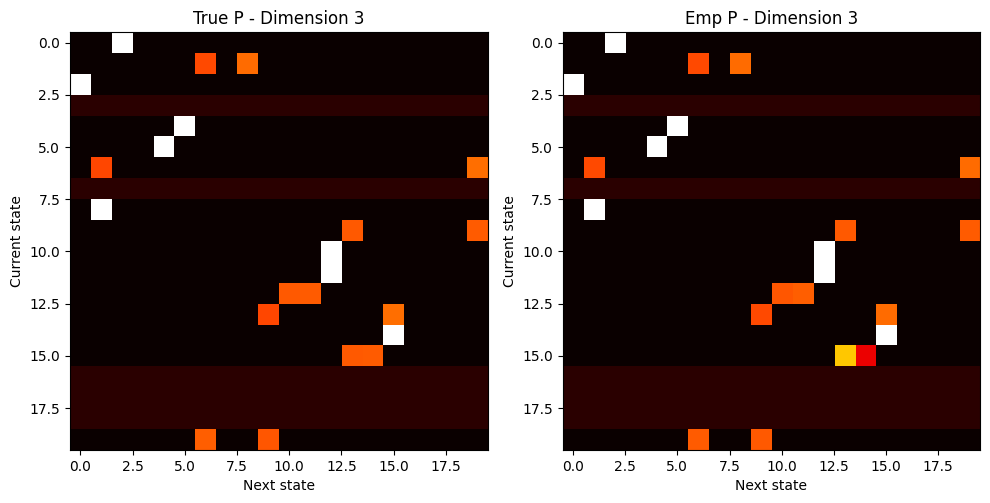

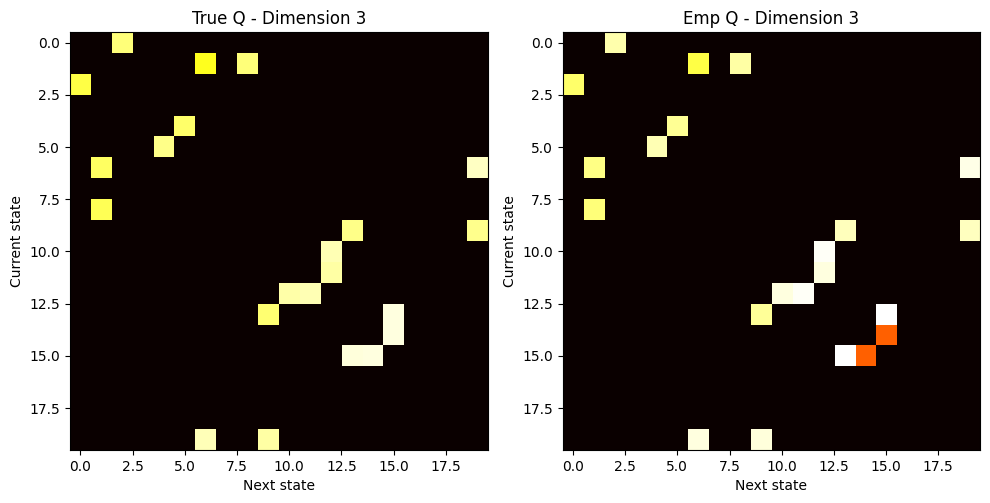

In [6]:
d = 3
marg_dims = tuple(np.delete(np.arange(2*D),[d,d+D]))
Q_marg = mct.Q.sum(marg_dims)
Q_obs_marg = mct_obs.Q.sum(marg_dims)
P_marg = qmat_to_pmat(Q_marg)
P_obs_marg = qmat_to_pmat(Q_obs_marg)

vmin = np.minimum(P_marg.min().item(), P_obs_marg.min().item())
vmax = np.maximum(P_marg.max().item(), P_obs_marg.max().item())
fig,axes = plt.subplots(1,2, figsize=(2*5,5)); 
ax = axes[0]
ax.imshow(P_marg,madmap, vmin=vmin, vmax=vmax)
ax.set_xlabel("Next state"); ax.set_ylabel("Current state")
ax.set_title(f"True P - Dimension {d}")
ax = axes[1]
ax.imshow(P_obs_marg,madmap, vmin=vmin, vmax=vmax)
ax.set_xlabel("Next state"); ax.set_ylabel("Current state")
ax.set_title(f"Emp P - Dimension {d}")
fig.tight_layout()

vmin = np.minimum(Q_marg.min().item(), Q_obs_marg.min().item())
vmax = np.maximum(Q_marg.max().item(), Q_obs_marg.max().item())
fig,axes = plt.subplots(1,2, figsize=(2*5,5)); 
ax = axes[0]
ax.imshow(Q_marg,madmap, vmin=vmin, vmax=vmax)
ax.set_xlabel("Next state"); ax.set_ylabel("Current state")
ax.set_title(f"True Q - Dimension {d}")
ax = axes[1]
ax.imshow(Q_obs_marg,madmap, vmin=vmin, vmax=vmax)
ax.set_xlabel("Next state"); ax.set_ylabel("Current state")
ax.set_title(f"Emp Q - Dimension {d}")
fig.tight_layout()


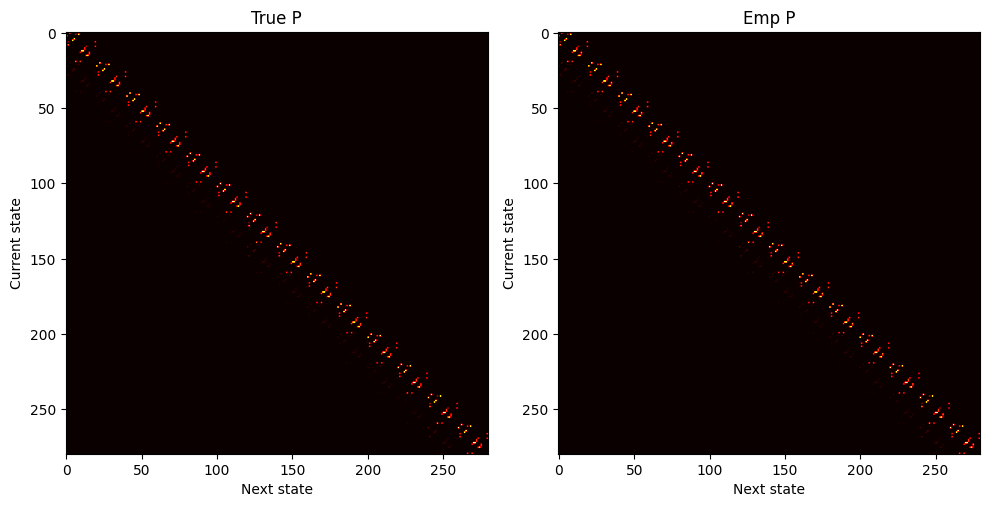

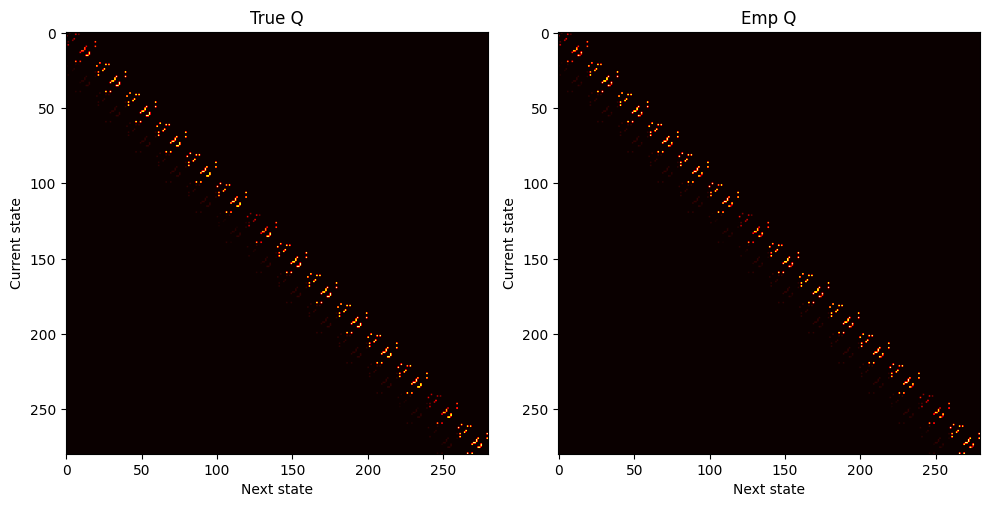

In [7]:
rng = np.arange(0,2*7*top_k)
# rng = np.arange(0,mct.I)
rng_inds = np.meshgrid(rng,rng)

vmin = np.minimum(mct._mcm.P.min().item(),mct_obs._mcm.P.min().item())
vmax = np.maximum(mct._mcm.P.max().item(),mct_obs._mcm.P.max().item())

fig,axes = plt.subplots(1,2, figsize=(2*5,5)); 
ax = axes[0]
ax.imshow(mct._mcm.P[rng_inds],madmap, vmin=vmin, vmax=vmax)
ax.set_xlabel("Next state"); ax.set_ylabel("Current state")
ax.set_title("True P")
ax = axes[1]
ax.imshow(mct_obs._mcm.P[rng_inds],madmap, vmin=vmin, vmax=vmax)
ax.set_xlabel("Next state"); ax.set_ylabel("Current state")
ax.set_title("Emp P")
fig.tight_layout()

vmin = np.minimum(mct._mcm.Q.min().item(),mct_obs._mcm.Q.min().item())
vmax = np.maximum(mct._mcm.Q.max().item(),mct_obs._mcm.Q.max().item())

fig,axes = plt.subplots(1,2, figsize=(2*5,5)); 
ax = axes[0]
ax.imshow(mct._mcm.Q[rng_inds],madmap, vmin=vmin, vmax=vmax)
ax.set_xlabel("Next state"); ax.set_ylabel("Current state")
ax.set_title("True Q")
ax = axes[1]
ax.imshow(mct_obs._mcm.Q[rng_inds],madmap, vmin=vmin, vmax=vmax)
ax.set_xlabel("Next state"); ax.set_ylabel("Current state")
ax.set_title("Emp Q")
fig.tight_layout()
